In [1]:
import pandas as pd
import numpy as np
import shap

In [2]:
import pickle
def save_data(data, outfile):
    with open(outfile, 'wb') as outf:
        pickle.dump(data, outf)

def load_data(infile):
    with open(infile, 'rb') as inf:
        data = pickle.load(inf)
    return data

In [3]:
import time
loca = time.strftime('%Y-%m-%d')

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
font_size = 10
rc={'font.size': font_size, 'axes.labelsize': font_size, 'figure.dpi':400, 'axes.linewidth':1, 'axes.edgecolor':'k',
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size} # 'figure.figsize':(11.7/1.5,8.27/1.5)

flatui_3risk = ['#e41a1c','#4daf4a','#ff7f00']
flatui_2cls = ['#377eb8', '#984ea3']

flatui = ['#ff7f00','#4daf4a','#984ea3','#377eb8', '#e41a1c']

sns.set(style='ticks',rc=rc) #talk, ticks, paper
sns.set_context("paper")
# sns.palplot(sns.color_palette(flatui))
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['savefig.dpi'] = 1000
plt.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams['axes.unicode_minus']=False # negative minus sign

centimeter = 1/2.54  # centimeter in inches


In [5]:
x_train,y_train=load_data('../data2023/train_AF0_230928.pkl')

In [6]:
x_train = x_train.drop(['exac_syn_z', 'exac_mis_z',
       'exac_lof_z', 'exac_pLI', 'exac_cnv_z',
       'RVIS_pop_maf_0_05', 'p_RVIS_pop_maf_0_05',
        'OE-ratio_ExAC_v2', 'p_OE-ratio_ExAC_v2', 'alternative-RVIS_maf_0_0025',
       'alternative-p_RVIS_maf_0_0025'], axis=1)

x_train.rename(columns={'gnomad_genome_controls_AF_popmax': 'AF'}, inplace=True)
x_train = x_train.drop(['Func','ExonicFunc'], axis=1)

x_train = x_train.drop(['stoploss','ncRNA','intergenic','stream'], axis=1)

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

clf=GradientBoostingClassifier(learning_rate=0.15, min_impurity_decrease=0,
                           min_samples_leaf=0.01, min_weight_fraction_leaf=0,
                           random_state=123, subsample=1)


In [9]:
x_test,y_test=load_data('../final_intermediate_file/ClinVar_test_2023-10-09.pkl')
x_test = x_test.drop(['stoploss','ncRNA','intergenic','stream'], axis=1)

In [12]:
# 老师方法2
mean_abs_shap_list = []
clf.fit(x_train, y_train)
explainer = shap.TreeExplainer(clf)
for i in range(100):
    X_train, X_test, Y_train, Y_test = train_test_split(x_test, y_test, test_size=0.2, stratify=y_test)
    shap_values = explainer.shap_values(X_test)
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    mean_abs_shap_list.append(mean_abs_shap)
    
mean_abs_shap_df = pd.DataFrame(mean_abs_shap_list, columns=x_train.columns)

In [10]:
print(mean_abs_shap_df.median())
print(mean_abs_shap_df.std())

AF                         1.467683
length                     0.350871
exonic                     0.618297
intronic                   0.210318
splicing                   0.084932
UTR                        0.066899
frameshift_deletion        0.066329
frameshift_insertion       0.007843
nonframeshift_deletion     0.042530
nonframeshift_insertion    0.013486
startloss                  0.009114
stopgain                   0.027502
Func_b                     1.104477
Func_p                     0.631906
ExonicFunc_b               0.060209
ExonicFunc_p               2.264898
dtype: float64
AF                         0.003867
length                     0.002740
exonic                     0.004949
intronic                   0.002279
splicing                   0.000482
UTR                        0.001913
frameshift_deletion        0.000688
frameshift_insertion       0.000029
nonframeshift_deletion     0.000305
nonframeshift_insertion    0.000028
startloss                  0.000008
stopgain     

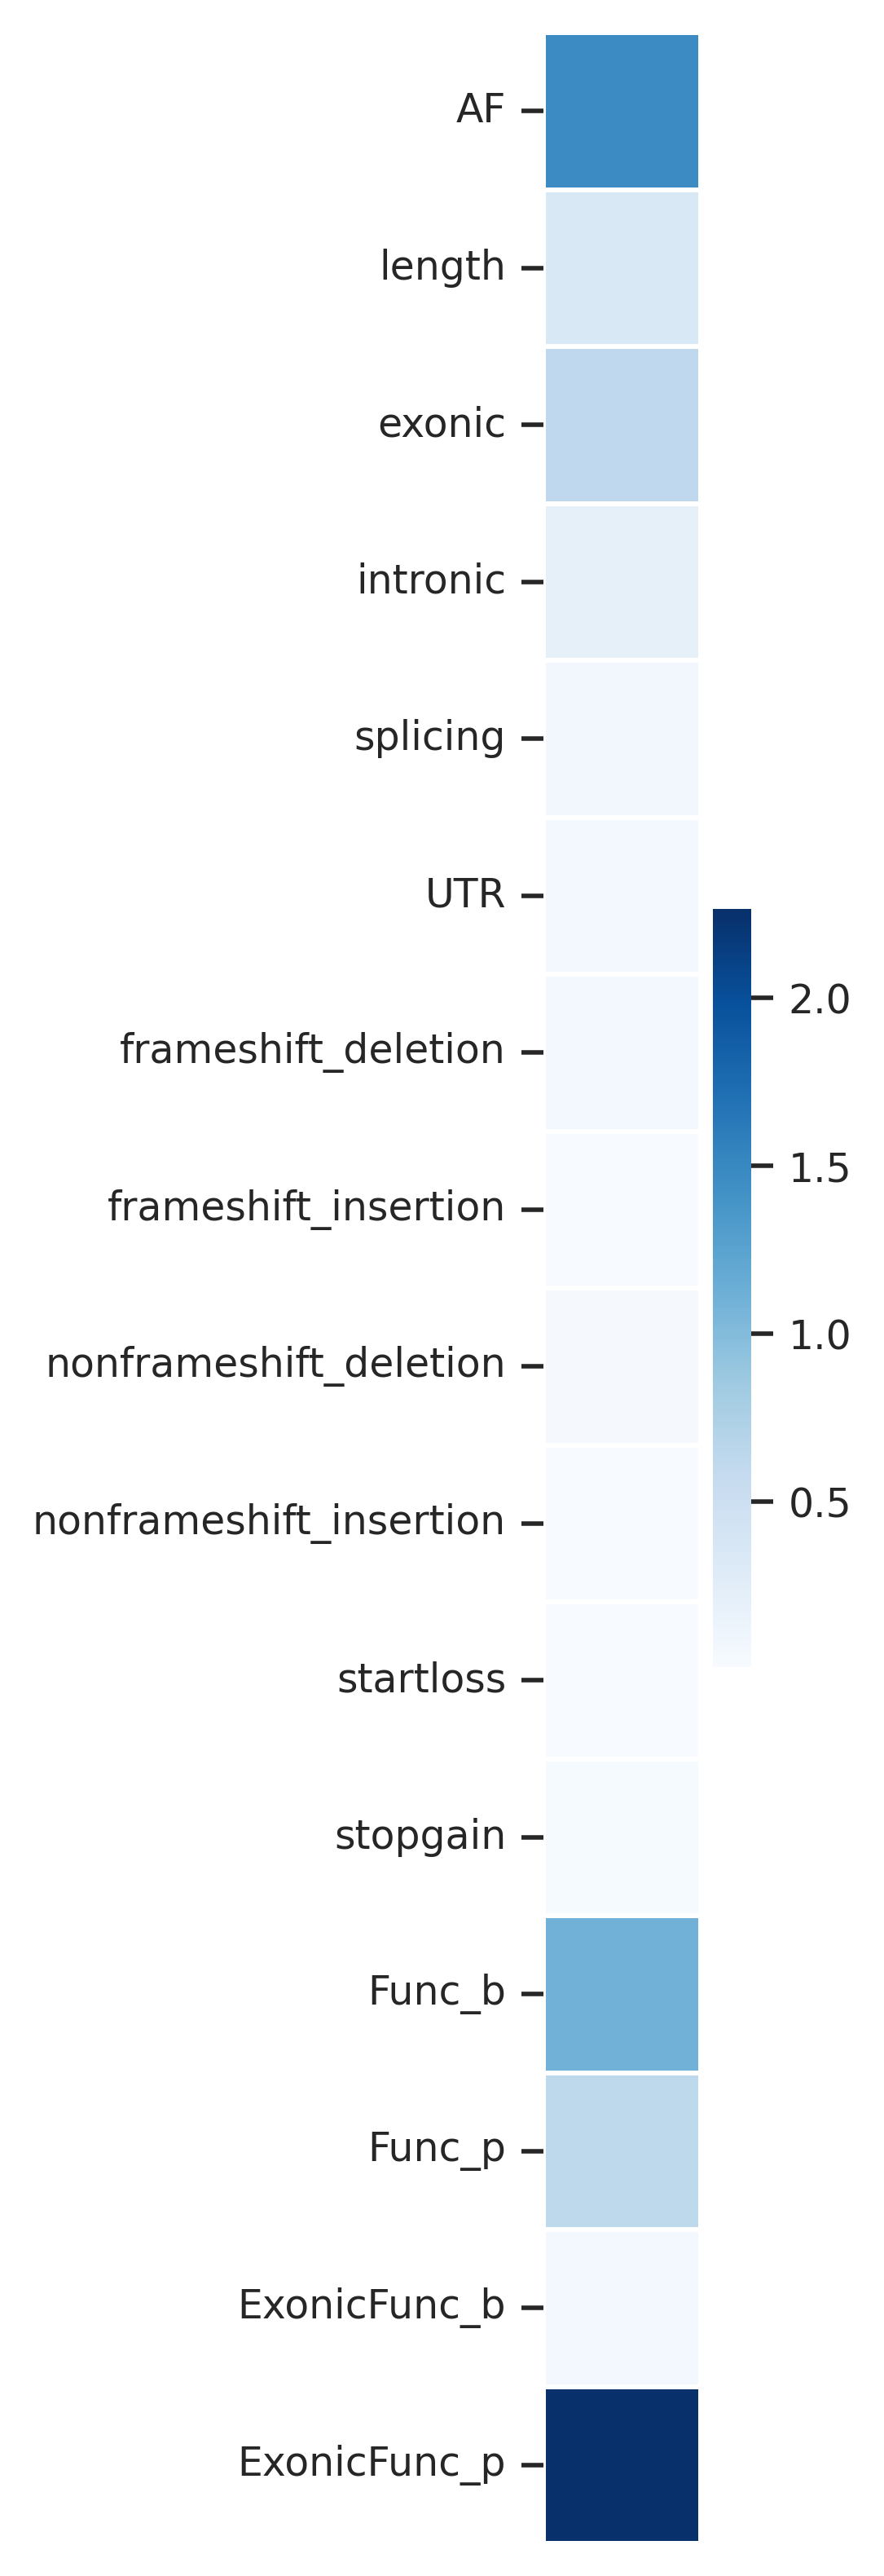

In [34]:
mean_abs_shap = mean_abs_shap_df.median()
data_for_heatmap = np.array(mean_abs_shap).reshape(-1, 1)

# 生成热图
plt.figure(figsize=(1, 10))
sns.heatmap(data_for_heatmap, annot=False, cmap='Blues', cbar=True, yticklabels=x_train.columns, xticklabels=[], square=True, linewidths=1)
plt.savefig(f"../final_fig/shap_importance_{loca}.pdf", bbox_inches='tight', format='pdf', dpi=1000)
plt.show()

In [13]:
# Create a DataFrame for ease of manipulation
df_shap = pd.DataFrame(shap_values)

# Calculate absolute sum of SHAP values by feature group
shap_sum_AF = df_shap.iloc[:, 0].abs()
shap_sum_Length = df_shap.iloc[:, 1].abs()
shap_sum_Function_based = df_shap.iloc[:, -4:].abs().sum(axis=1)
shap_sum_Gene_based = df_shap.iloc[:, 2:-4].abs().sum(axis=1)

# Calculate total absolute sum of SHAP values for normalization
total_shap_sum = shap_sum_AF + shap_sum_Length + shap_sum_Function_based + shap_sum_Gene_based

# Normalize the SHAP values
normalized_shap_AF = shap_sum_AF / total_shap_sum
normalized_shap_Length = shap_sum_Length / total_shap_sum
normalized_shap_Function_based = shap_sum_Function_based / total_shap_sum
normalized_shap_Gene_based = shap_sum_Gene_based / total_shap_sum

# Now you have the normalized SHAP values by feature group with their respective names
print("Normalized SHAP for AF:", np.mean(normalized_shap_AF))
print("Normalized SHAP for Length:", np.mean(normalized_shap_Length))
print("Normalized SHAP for Function-based:", np.mean(normalized_shap_Function_based))
print("Normalized SHAP for Gene-based:", np.mean(normalized_shap_Gene_based))

df_normalized = pd.DataFrame({
    'AF': normalized_shap_AF,
    'Length': normalized_shap_Length,
    'Gene-based feature': normalized_shap_Gene_based,
    'Function-based feature': normalized_shap_Function_based
})

Normalized SHAP for AF: 0.2085474935529511
Normalized SHAP for Length: 0.053235663636262004
Normalized SHAP for Function-based: 0.5760691343468752
Normalized SHAP for Gene-based: 0.1621477084639117


In [ ]:
# 计算每个列的总和
column_sums = df_normalized.sum()
colors = ["#DF7A5E","#3C405B", "#82B29A", "#F2CC8E", "#3B8BC2"]

# 绘制饼图
plt.figure(figsize=(4, 4))
plt.pie(column_sums, labels=column_sums.index, autopct='%1.1f%%', colors=colors, startangle=140)
plt.axis('equal')
plt.savefig(f"../final_fig/shap_values_distribution_pipe_exac_{loca}.pdf", format="pdf", dpi=1000, bbox_inches='tight')
plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


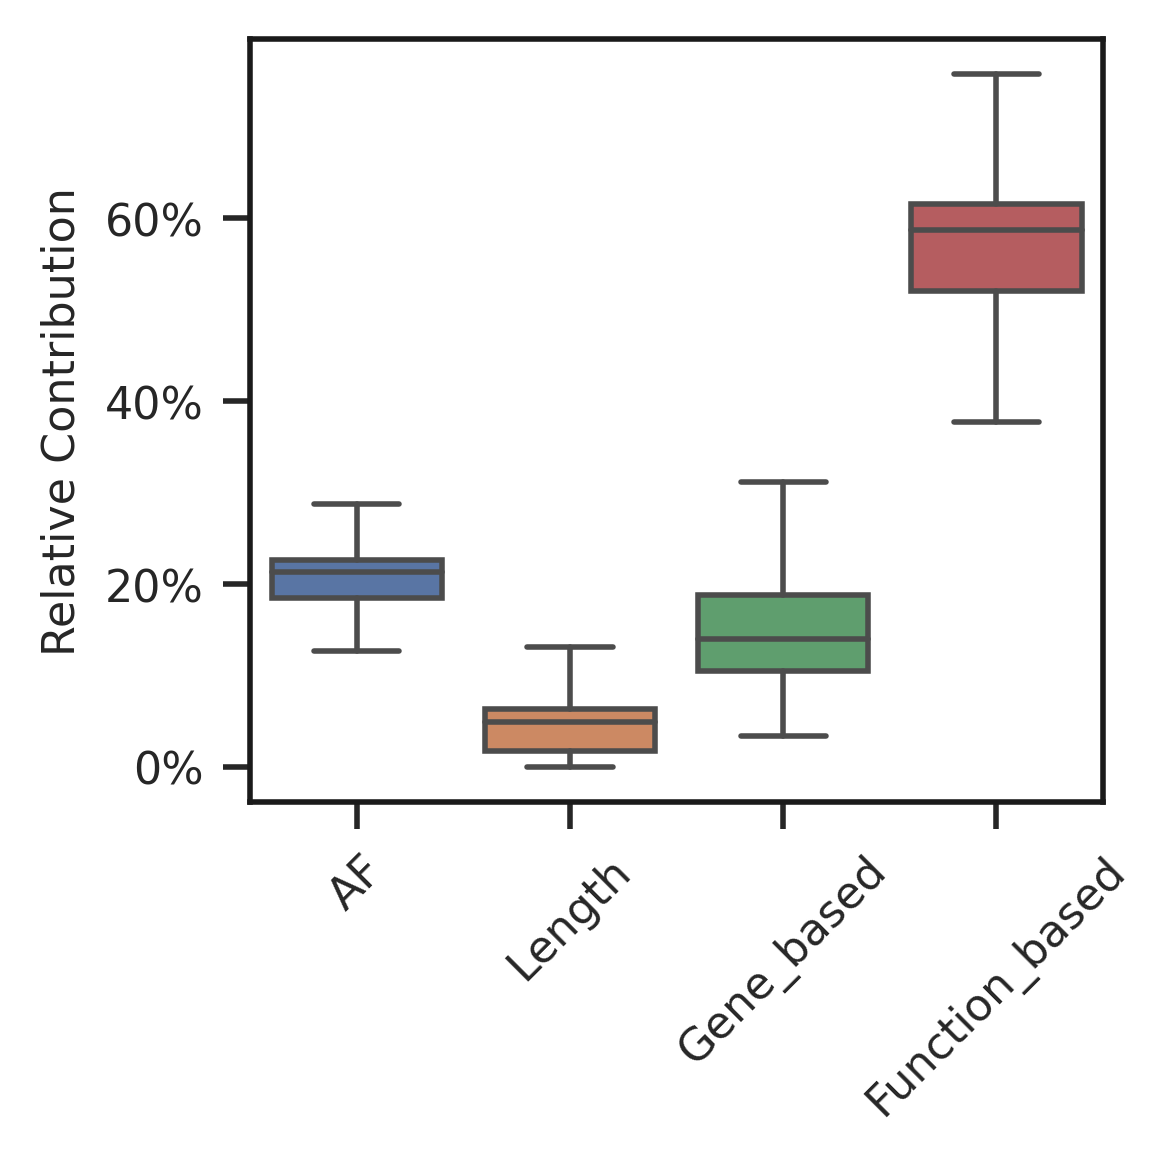

In [22]:
from matplotlib.ticker import FuncFormatter

def to_percentage(x, _):
    return '{:.0f}%'.format(100 * x)

plt.figure(figsize=(3, 3))
sns.boxplot(data=df_normalized, showfliers=False, linewidth=1,width=0.8)
formatter = FuncFormatter(to_percentage)
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylabel('Relative Contribution', fontsize=8)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(f"../final_fig/shap_values_distribution_{loca}.pdf", format="pdf", dpi=1000, bbox_inches='tight')
plt.show()

In [14]:
from scipy.stats import zscore
# Calculate the z-scores of the SHAP values
shap_zscores = zscore(shap_values, axis=0)
if np.any(np.isnan(shap_zscores)) or np.any(np.isinf(shap_zscores)):
    shap_zscores = np.nan_to_num(shap_zscores)

In [15]:
# Convert to DataFrame for better labeling in heatmap
df_shap_zscores = pd.DataFrame(shap_zscores, columns=X_test.columns)

# Add y_train as a 'tag' column
df_shap_zscores['tag'] = Y_test.values

# Create a color palette for the 'tag' column
default_palette = sns.color_palette()
tag_palette = {0: "#3C405B", 1: "#F2CC8E"}
col_colors = df_shap_zscores['tag'].map(tag_palette)

# Drop 'tag' column for the clustering
df_shap_zscores.drop(columns='tag', inplace=True)

In [12]:
df_shap_zscores.head()

,AF,length,exonic,intronic,splicing,UTR,frameshift_deletion,frameshift_insertion,nonframeshift_deletion,nonframeshift_insertion,startloss,stopgain,Func_b,Func_p,ExonicFunc_b,ExonicFunc_p
0,0.191670,0.565282,0.685038,0.545622,0.014627,-0.111338,-1.977107,-0.009472,0.121830,0.936363,0.721439,-0.692318,0.644724,0.622538,-0.176579,0.799547
1,0.050088,0.711844,-0.691014,-0.222372,-0.503633,-0.164959,0.366709,-0.009472,0.166309,0.728668,0.721439,-0.857513,0.697342,0.659226,0.472183,0.709054
2,0.184492,0.747599,0.689901,-0.221651,1.500221,-0.153460,0.322475,-0.009472,0.121830,0.959741,0.721439,-0.456894,0.717302,0.631581,-0.292010,0.729621
3,0.709195,-1.157676,-1.838243,-0.236674,-1.282187,-0.172269,0.655788,-2.394571,-6.585060,-2.361259,-1.386119,3.627289,0.292727,1.075560,0.440393,-1.121227
4,0.184740,-0.968664,0.842417,-0.321293,-0.582378,-0.154497,0.609756,-0.009472,-0.305351,-0.211672,0.721439,-0.720564,0.650386,0.659292,-0.336209,0.677043


In [ ]:
"#82B29A", "#F2CC8E",  "#DF7A5E", "#3C405B"

In [8]:
import matplotlib.colors as mcolors

# 创建自定义颜色映射
colors = ["#F2CC8E", "#E0E0E0", "#82B29A"]
gyr = ["#3B8BC2", "#E0E0E0", "#DF7A5E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", gyr)

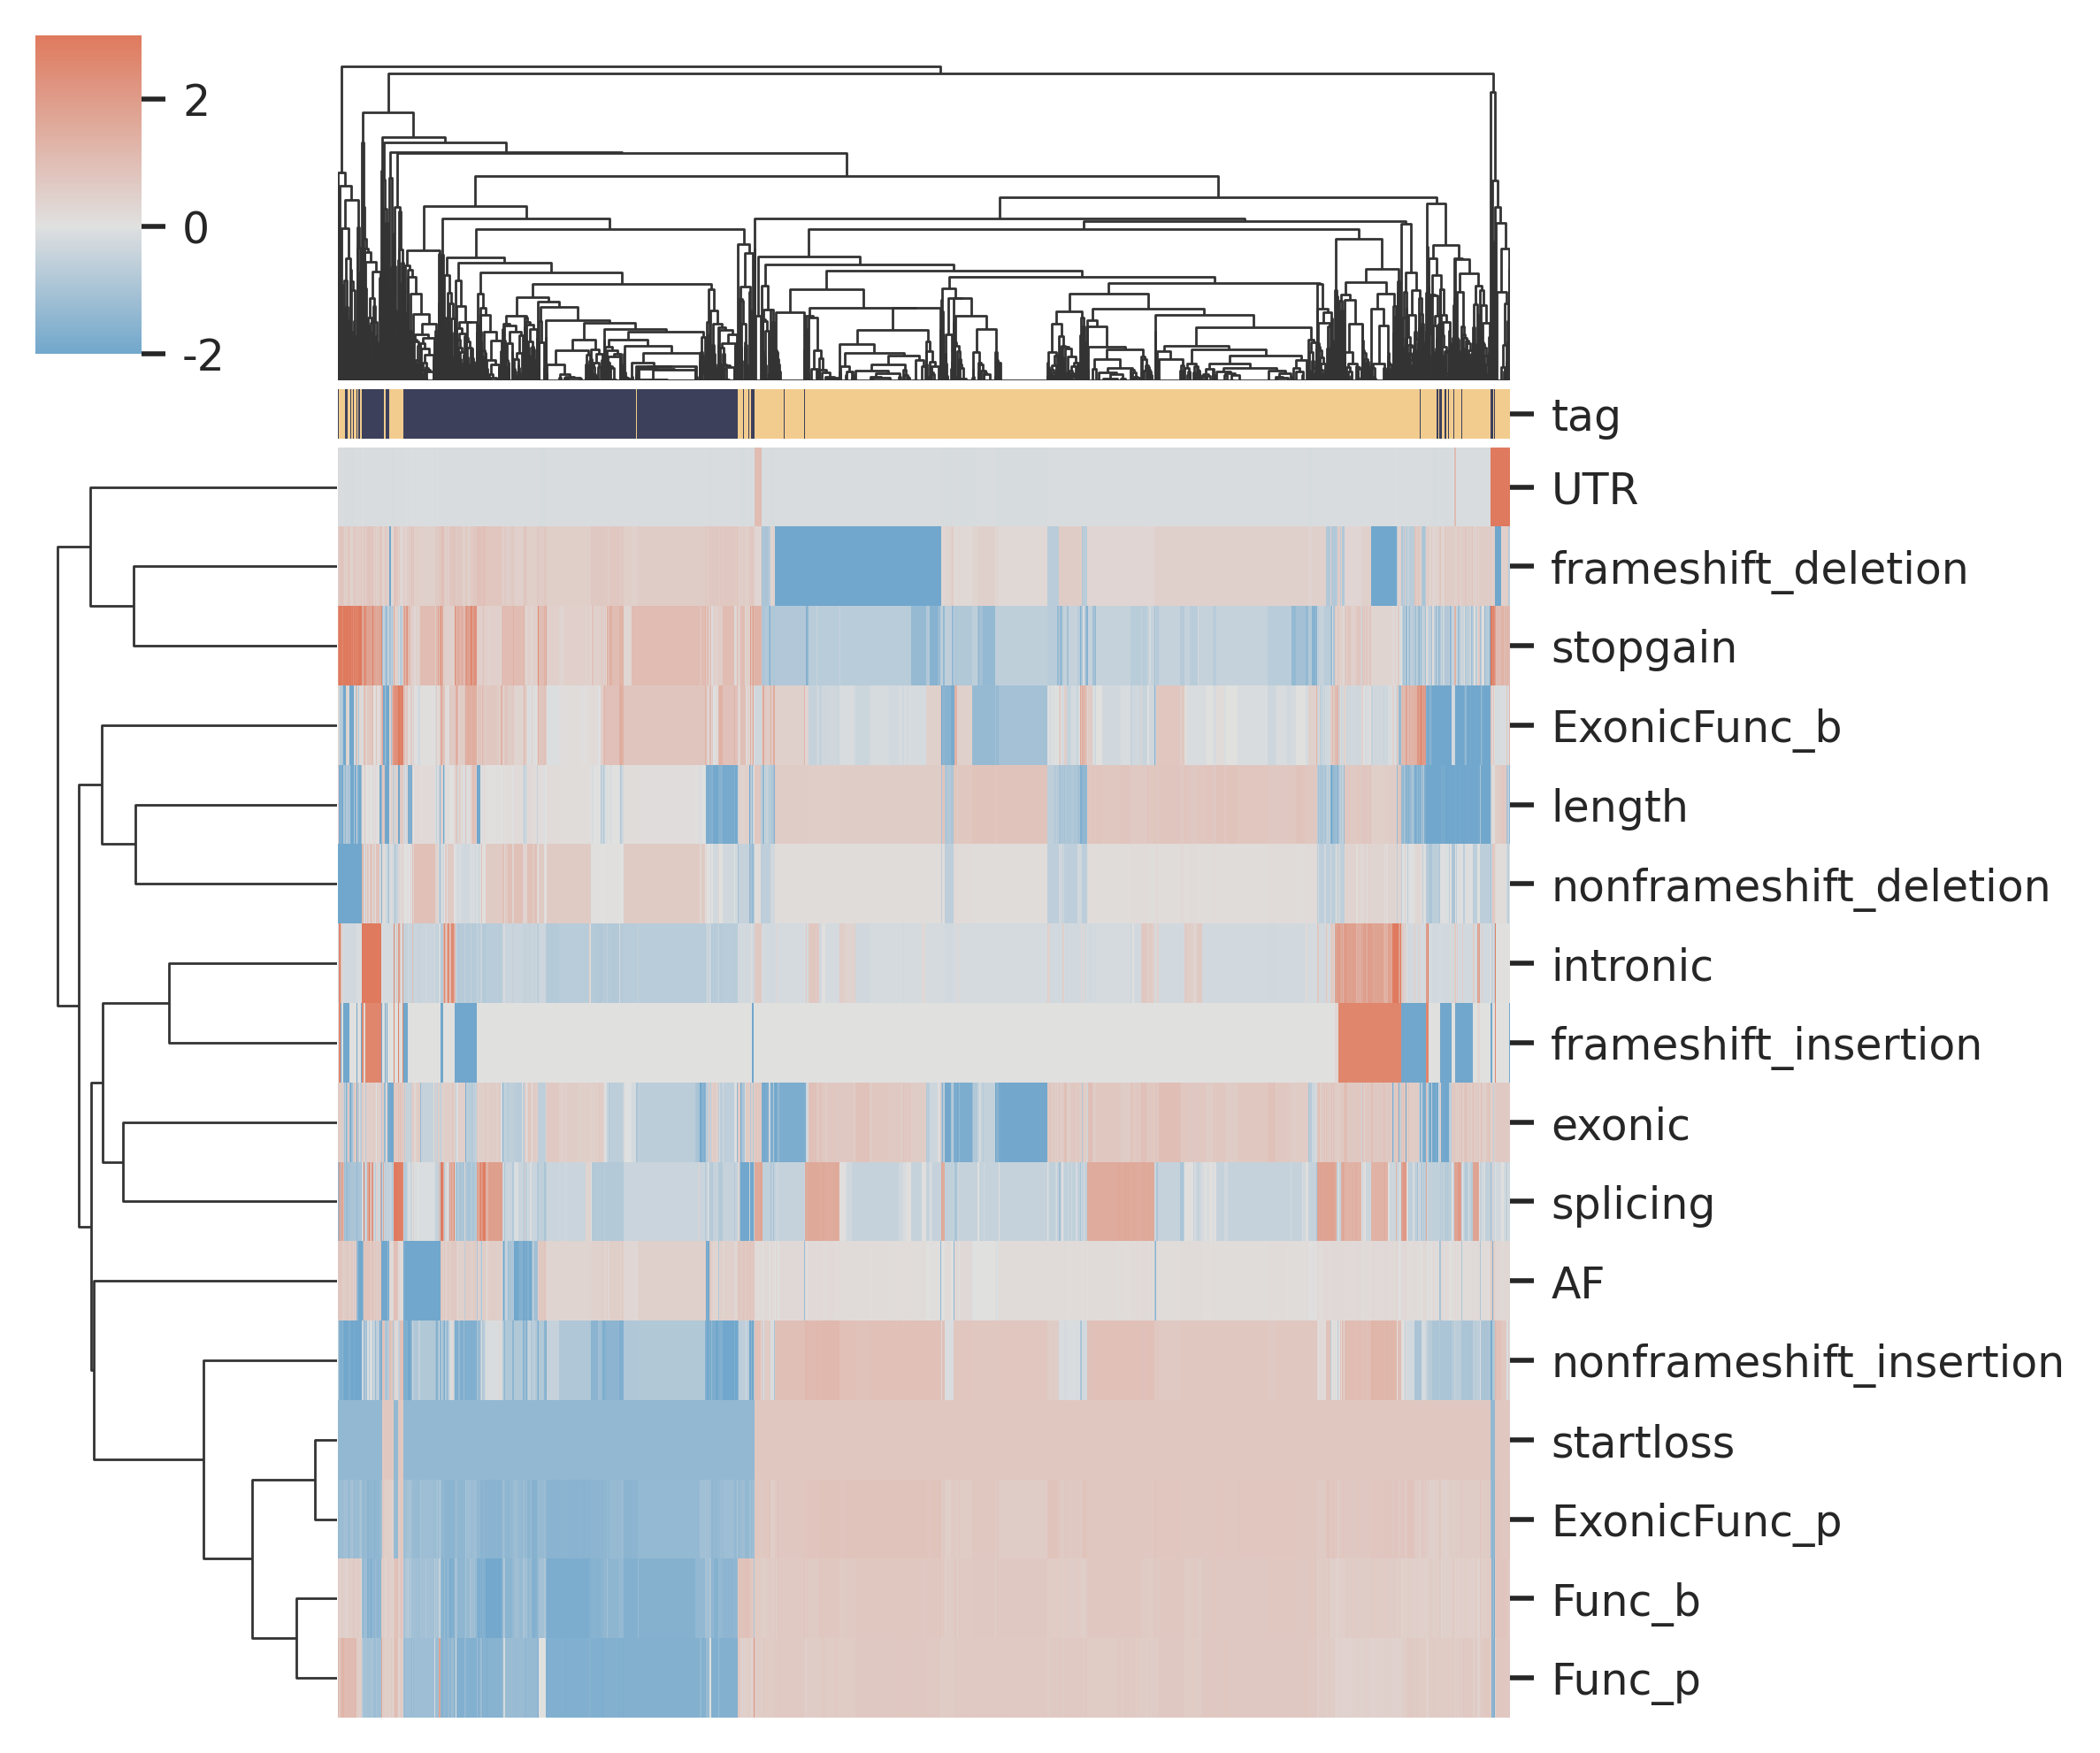

In [27]:
# Create clustermap using seaborn
sns.clustermap(df_shap_zscores.transpose(), 
               cmap=cmap, 
               center=0, 
               vmax=3,
               vmin=-2,
               col_colors=col_colors, 
               figsize=(6, 5), 
               col_cluster=True, 
               row_cluster=True, 
               cbar_kws={"shrink": 0.75},
               xticklabels=False)
plt.savefig(f"../final_fig/shap_values_clustermap_{loca}.png", format="png", dpi=1000, bbox_inches='tight')
plt.show()

In [21]:
x_test_normalized.describe()

,AF,length,exonic,intronic,splicing,UTR,frameshift_deletion,frameshift_insertion,nonframeshift_deletion,nonframeshift_insertion,startloss,stopgain,Func_b,Func_p,ExonicFunc_b,ExonicFunc_p
count,4.938500e+04,4.938500e+04,4.938500e+04,4.938500e+04,4.938500e+04,4.938500e+04,4.938500e+04,4.938500e+04,4.938500e+04,4.938500e+04,4.938500e+04,4.938500e+04,4.938500e+04,4.938500e+04,4.938500e+04,4.938500e+04
mean,1.248144e-17,4.517777e-17,-6.543583e-16,1.496334e-17,7.035646e-17,3.992621e-17,1.024413e-16,-4.195490e-16,-2.189827e-16,-2.244501e-16,-8.920451e-18,3.737957e-16,-9.150657e-17,-3.519262e-16,7.035646e-17,-1.582661e-17
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00
min,-9.111837e-02,-3.757148e-01,-2.725494e+00,-2.613452e-01,-7.176287e-01,-1.050653e-01,-1.446499e+00,-1.446499e+00,-1.446499e+00,-1.446499e+00,-1.446499e+00,-1.446499e+00,-6.356356e-01,-1.655495e+00,-7.058112e-01,-1.348272e+00
25%,-9.111837e-02,-3.757148e-01,-1.259461e+00,-2.613452e-01,-7.176287e-01,-1.050653e-01,-1.446499e+00,-1.446499e+00,-1.446499e+00,-1.446499e+00,-1.446499e+00,-1.446499e+00,-6.356356e-01,-1.448648e+00,-7.058112e-01,-1.348272e+00
50%,-9.111837e-02,-3.757148e-01,2.418581e-01,-2.613452e-01,-7.176287e-01,-1.050653e-01,6.913241e-01,6.913241e-01,6.913241e-01,6.913241e-01,6.913241e-01,6.913241e-01,-6.356356e-01,6.912042e-01,-6.806737e-01,7.318315e-01
75%,-9.111837e-02,-9.776148e-03,8.460525e-01,-2.613452e-01,9.004096e-01,-1.050653e-01,6.913241e-01,6.913241e-01,6.913241e-01,6.913241e-01,6.913241e-01,6.913241e-01,1.577659e+00,6.912042e-01,1.445745e+00,7.318315e-01
max,2.668055e+01,1.170026e+01,1.394689e+00,2.030646e+01,1.902980e+00,2.872615e+01,6.913241e-01,6.913241e-01,6.913241e-01,6.913241e-01,6.913241e-01,6.913241e-01,1.577659e+00,6.912042e-01,1.445745e+00,1.017186e+00


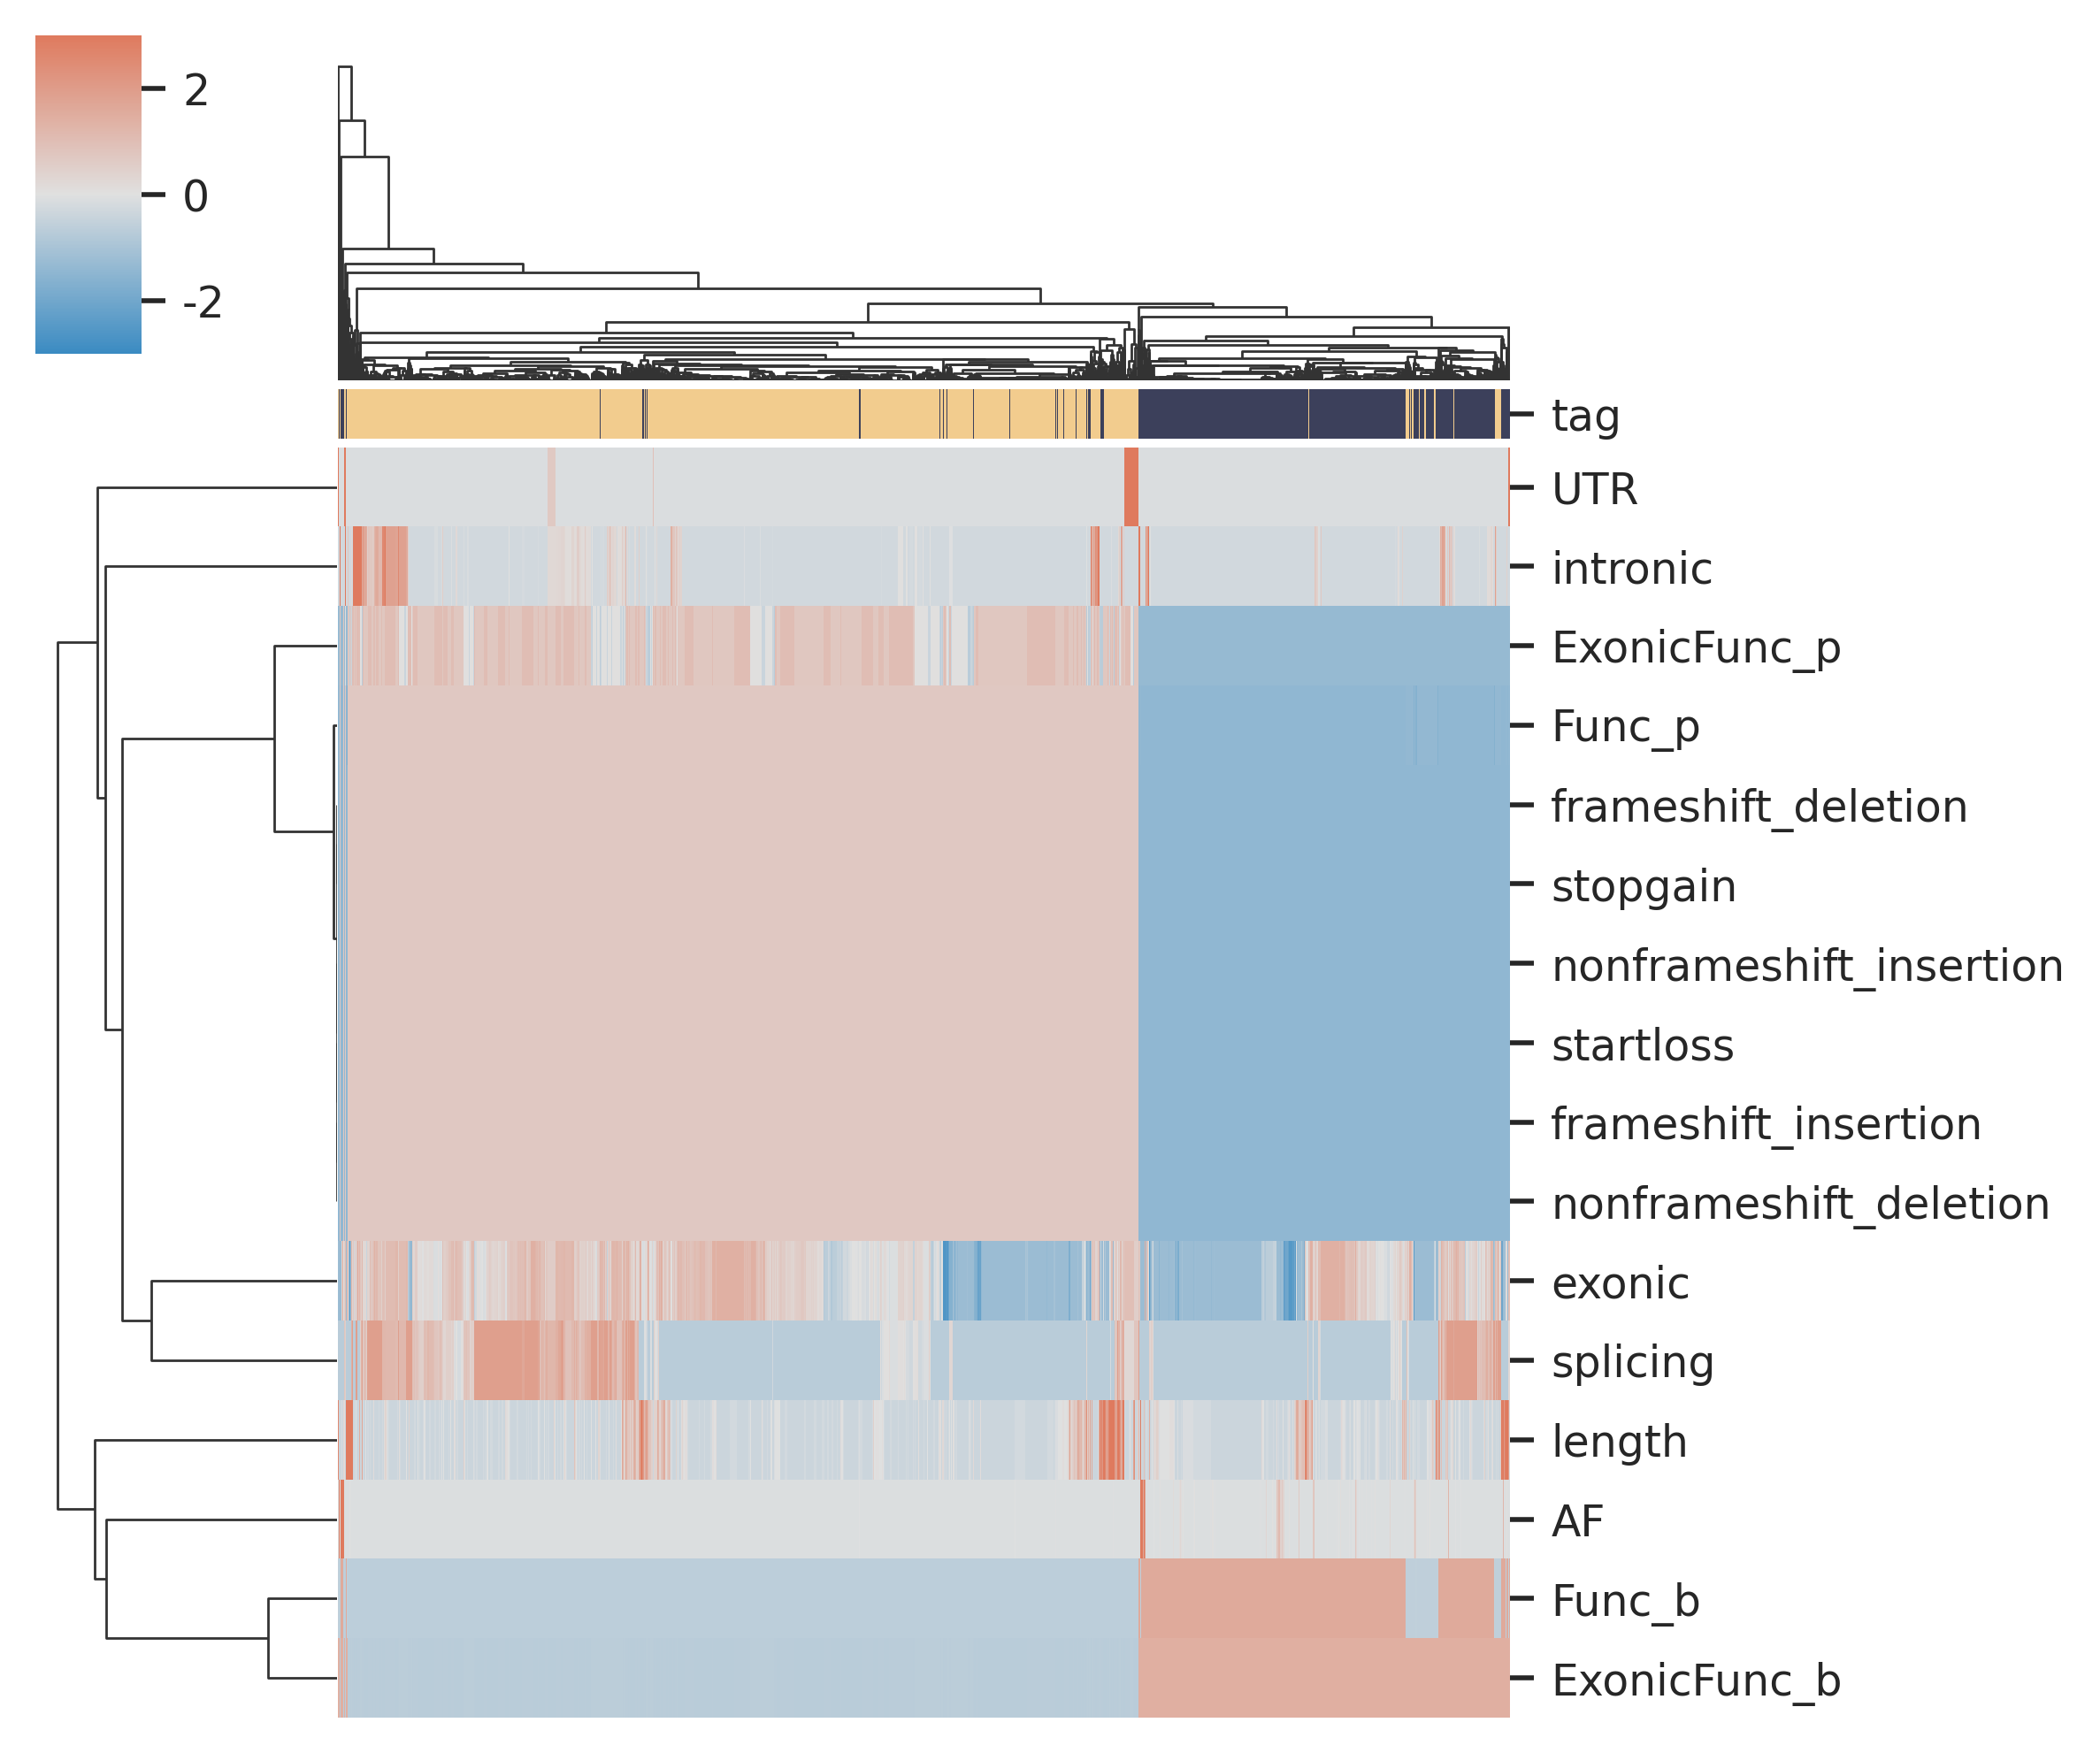

In [30]:
# 直接对数值做聚类
from scipy.stats import zscore
x_test_normalized = x_test.apply(zscore)

default_palette = sns.color_palette()
tag_palette = {0: "#3C405B", 1: "#F2CC8E"}
col_colors = y_test.map(tag_palette)
sns.clustermap(x_test_normalized.transpose(), 
               cmap=cmap, 
               center=0, 
               vmax=3,
               vmin=-3,
               col_colors=col_colors, 
               figsize=(6, 5), 
               col_cluster=True, 
               row_cluster=True, 
               cbar_kws={"shrink": 0.75},
               xticklabels=False)
plt.savefig(f"../final_fig/shap_values_clustermap_{loca}.pdf", format="pdf", dpi=1000, bbox_inches='tight')
plt.savefig(f"../final_fig/shap_values_clustermap_{loca}.png", format="png", dpi=1000, bbox_inches='tight')
plt.show()

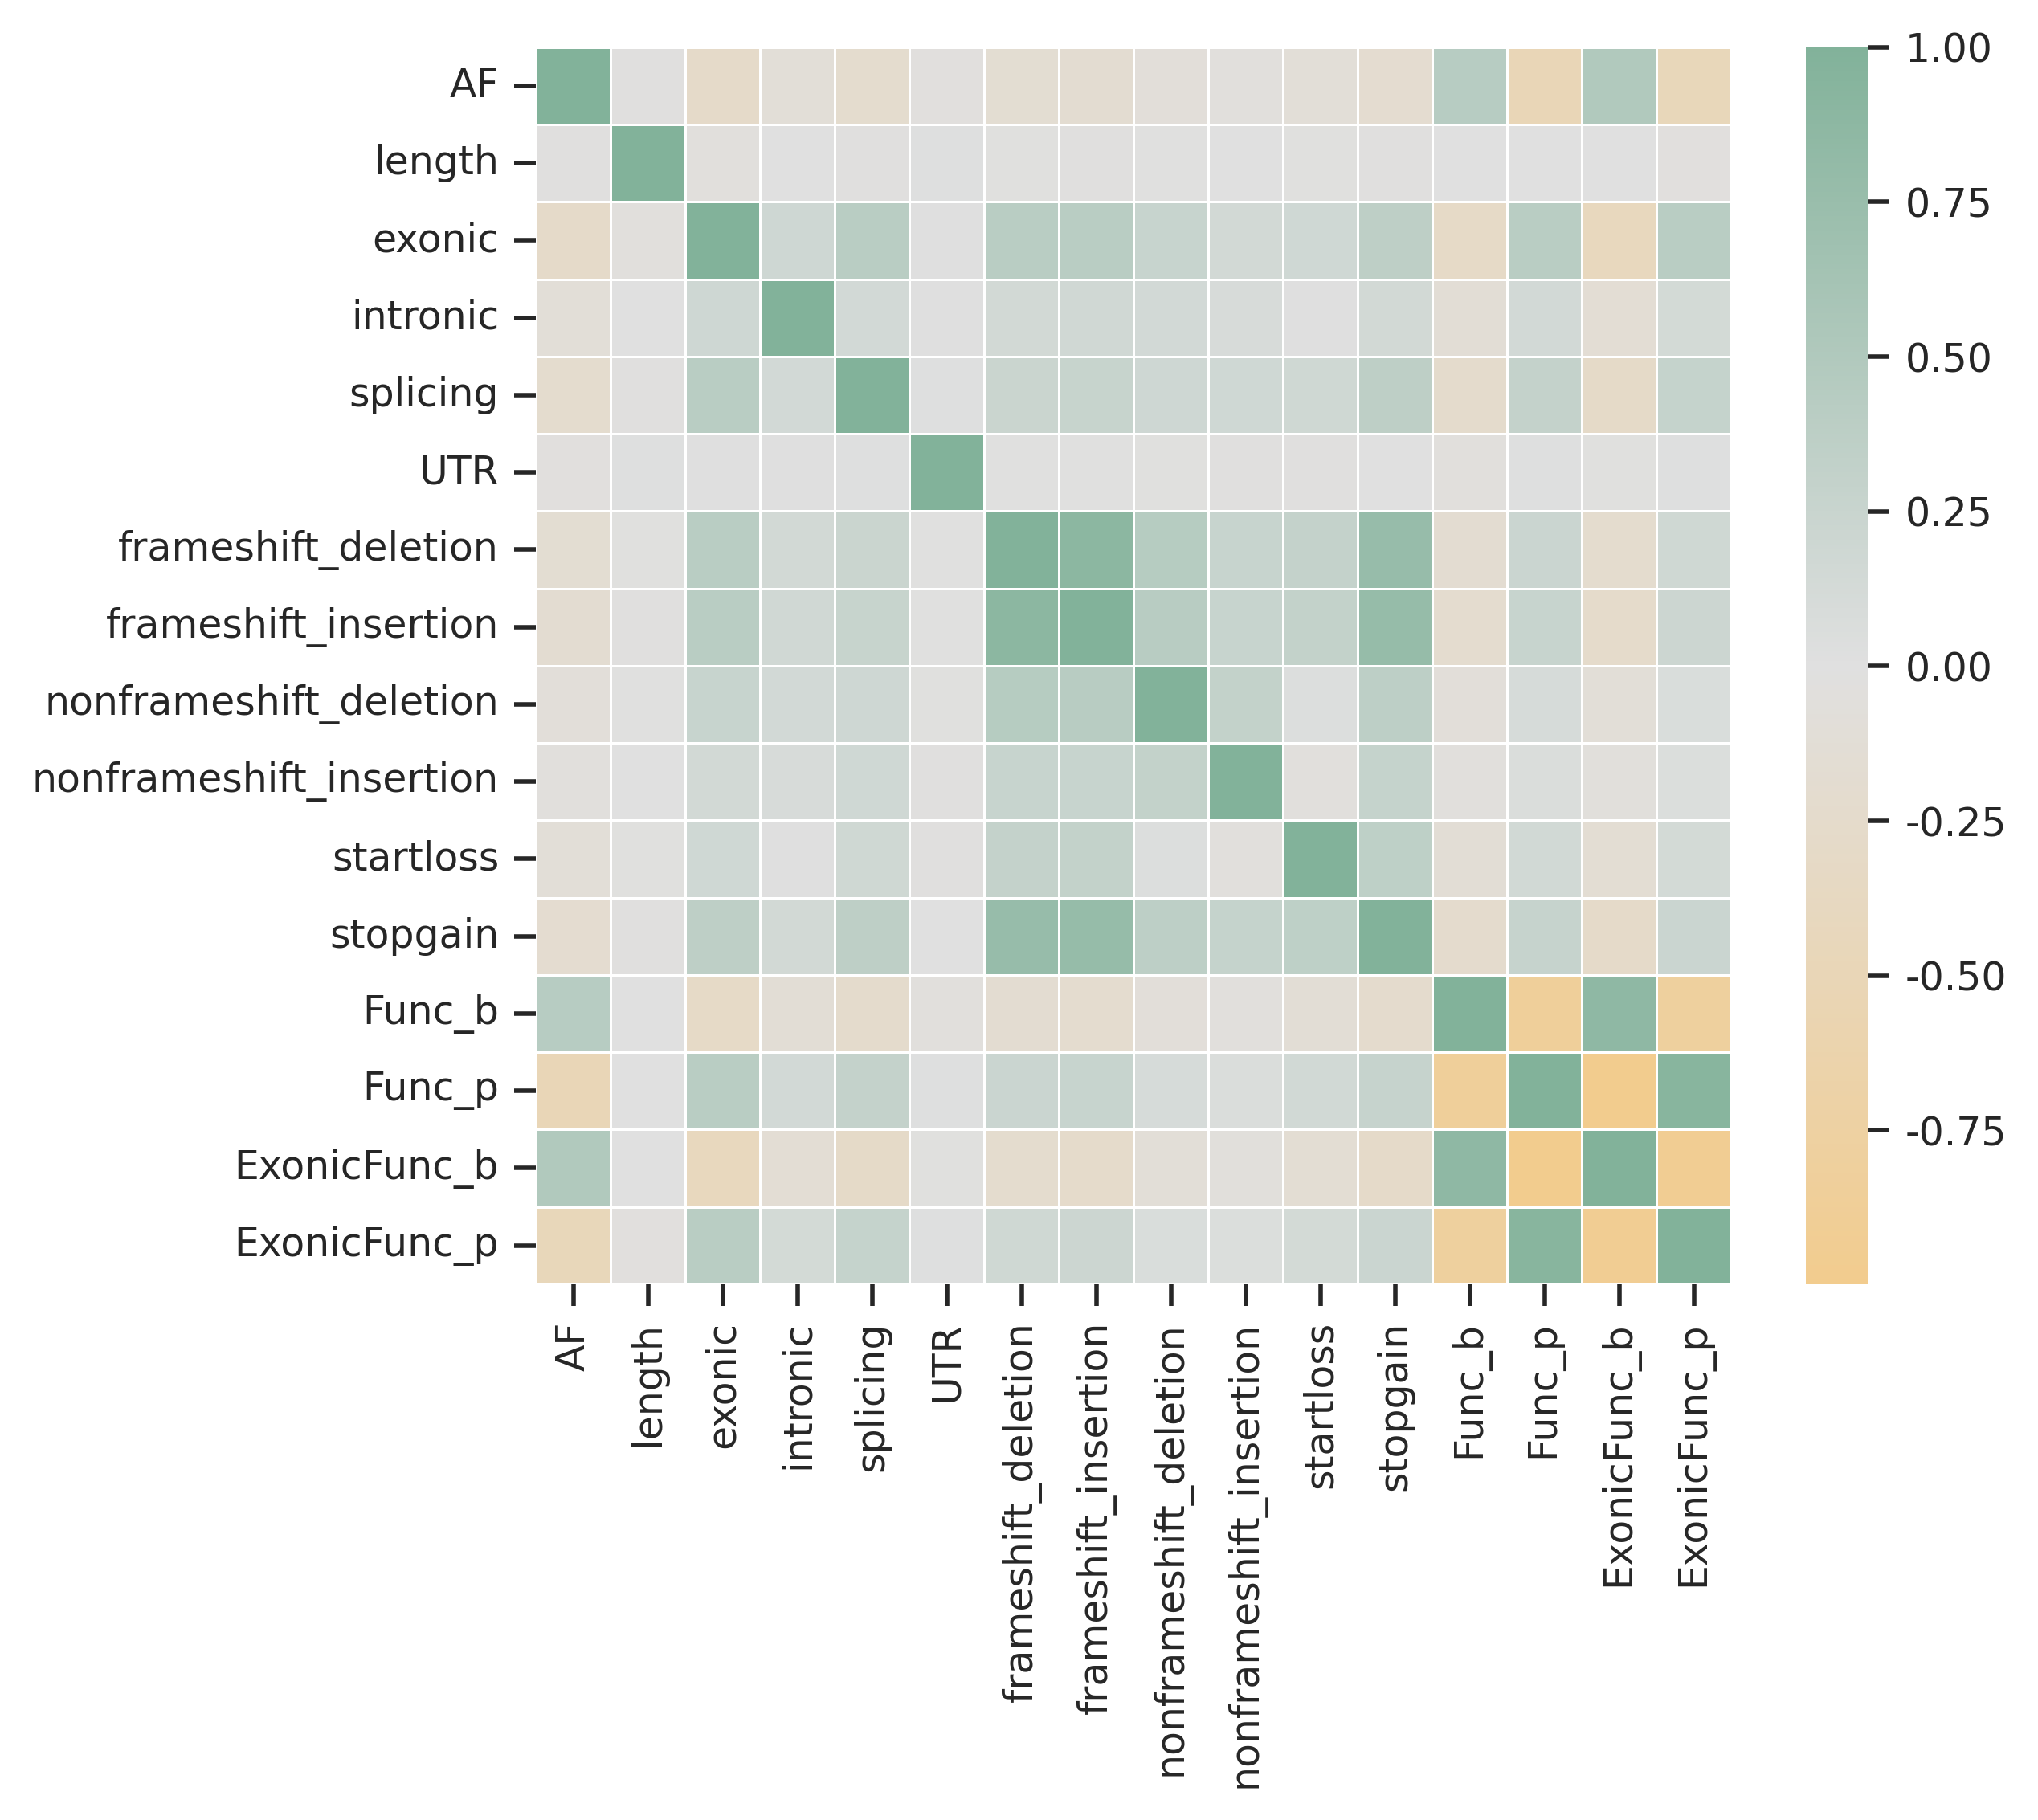

In [37]:
correlation_matrix = x_train.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, cmap=cmap, linewidths=0.5)
plt.savefig(f"../final_fig/feature_corr_{loca}.pdf", format="pdf", dpi=1000, bbox_inches='tight')
plt.show()


# 比较不同的AF处理方式造成性能的不同

In [59]:
%run 1_INDELpred_train.py

In [61]:
from sklearn.metrics import roc_auc_score

model_best = load_data('../data2023/INDELpred_model_in_pyfile_2023-10-08.pkl')
model_cutoff = load_data('../data2023/INDELpred_model_cutoff_2023-10-11.pkl')

clinvar_x, clinvar_y = load_data("../final_intermediate_file/ClinVar_test_2023-10-09.pkl")
VKGL_x, VKGL_y = load_data("../final_intermediate_file/VKGL_test_2023-10-09.pkl")
HGMD_x, HGMD_y = load_data("../final_intermediate_file/HGMD_test_2023-10-09.pkl")

In [84]:
def preprocess_data_for_model(x, model_type):
    x_processed = x.copy()
    
    if model_type == 'model_cutoff':
        af_cut_off = 0.005
        x_processed.loc[x_processed['AF'] > af_cut_off, 'AF'] = 1
        x_processed.loc[x_processed['AF'] <= af_cut_off, 'AF'] = 0
        af_column = x_processed['AF']
        x_processed = x_processed.drop('AF', axis=1)
        x_processed['AF'] = af_column
        
    return x_processed

def calculate_auc(model, x, y_true, model_type):
    x_processed = preprocess_data_for_model(x, model_type)
    y_pred = model.predict_proba(x_processed)[:, 1]
    return roc_auc_score(y_true, y_pred)

# 使用方式
# auc_value = calculate_auc(model_instance, x_test1, y_true_test1, 'model_cutoff')


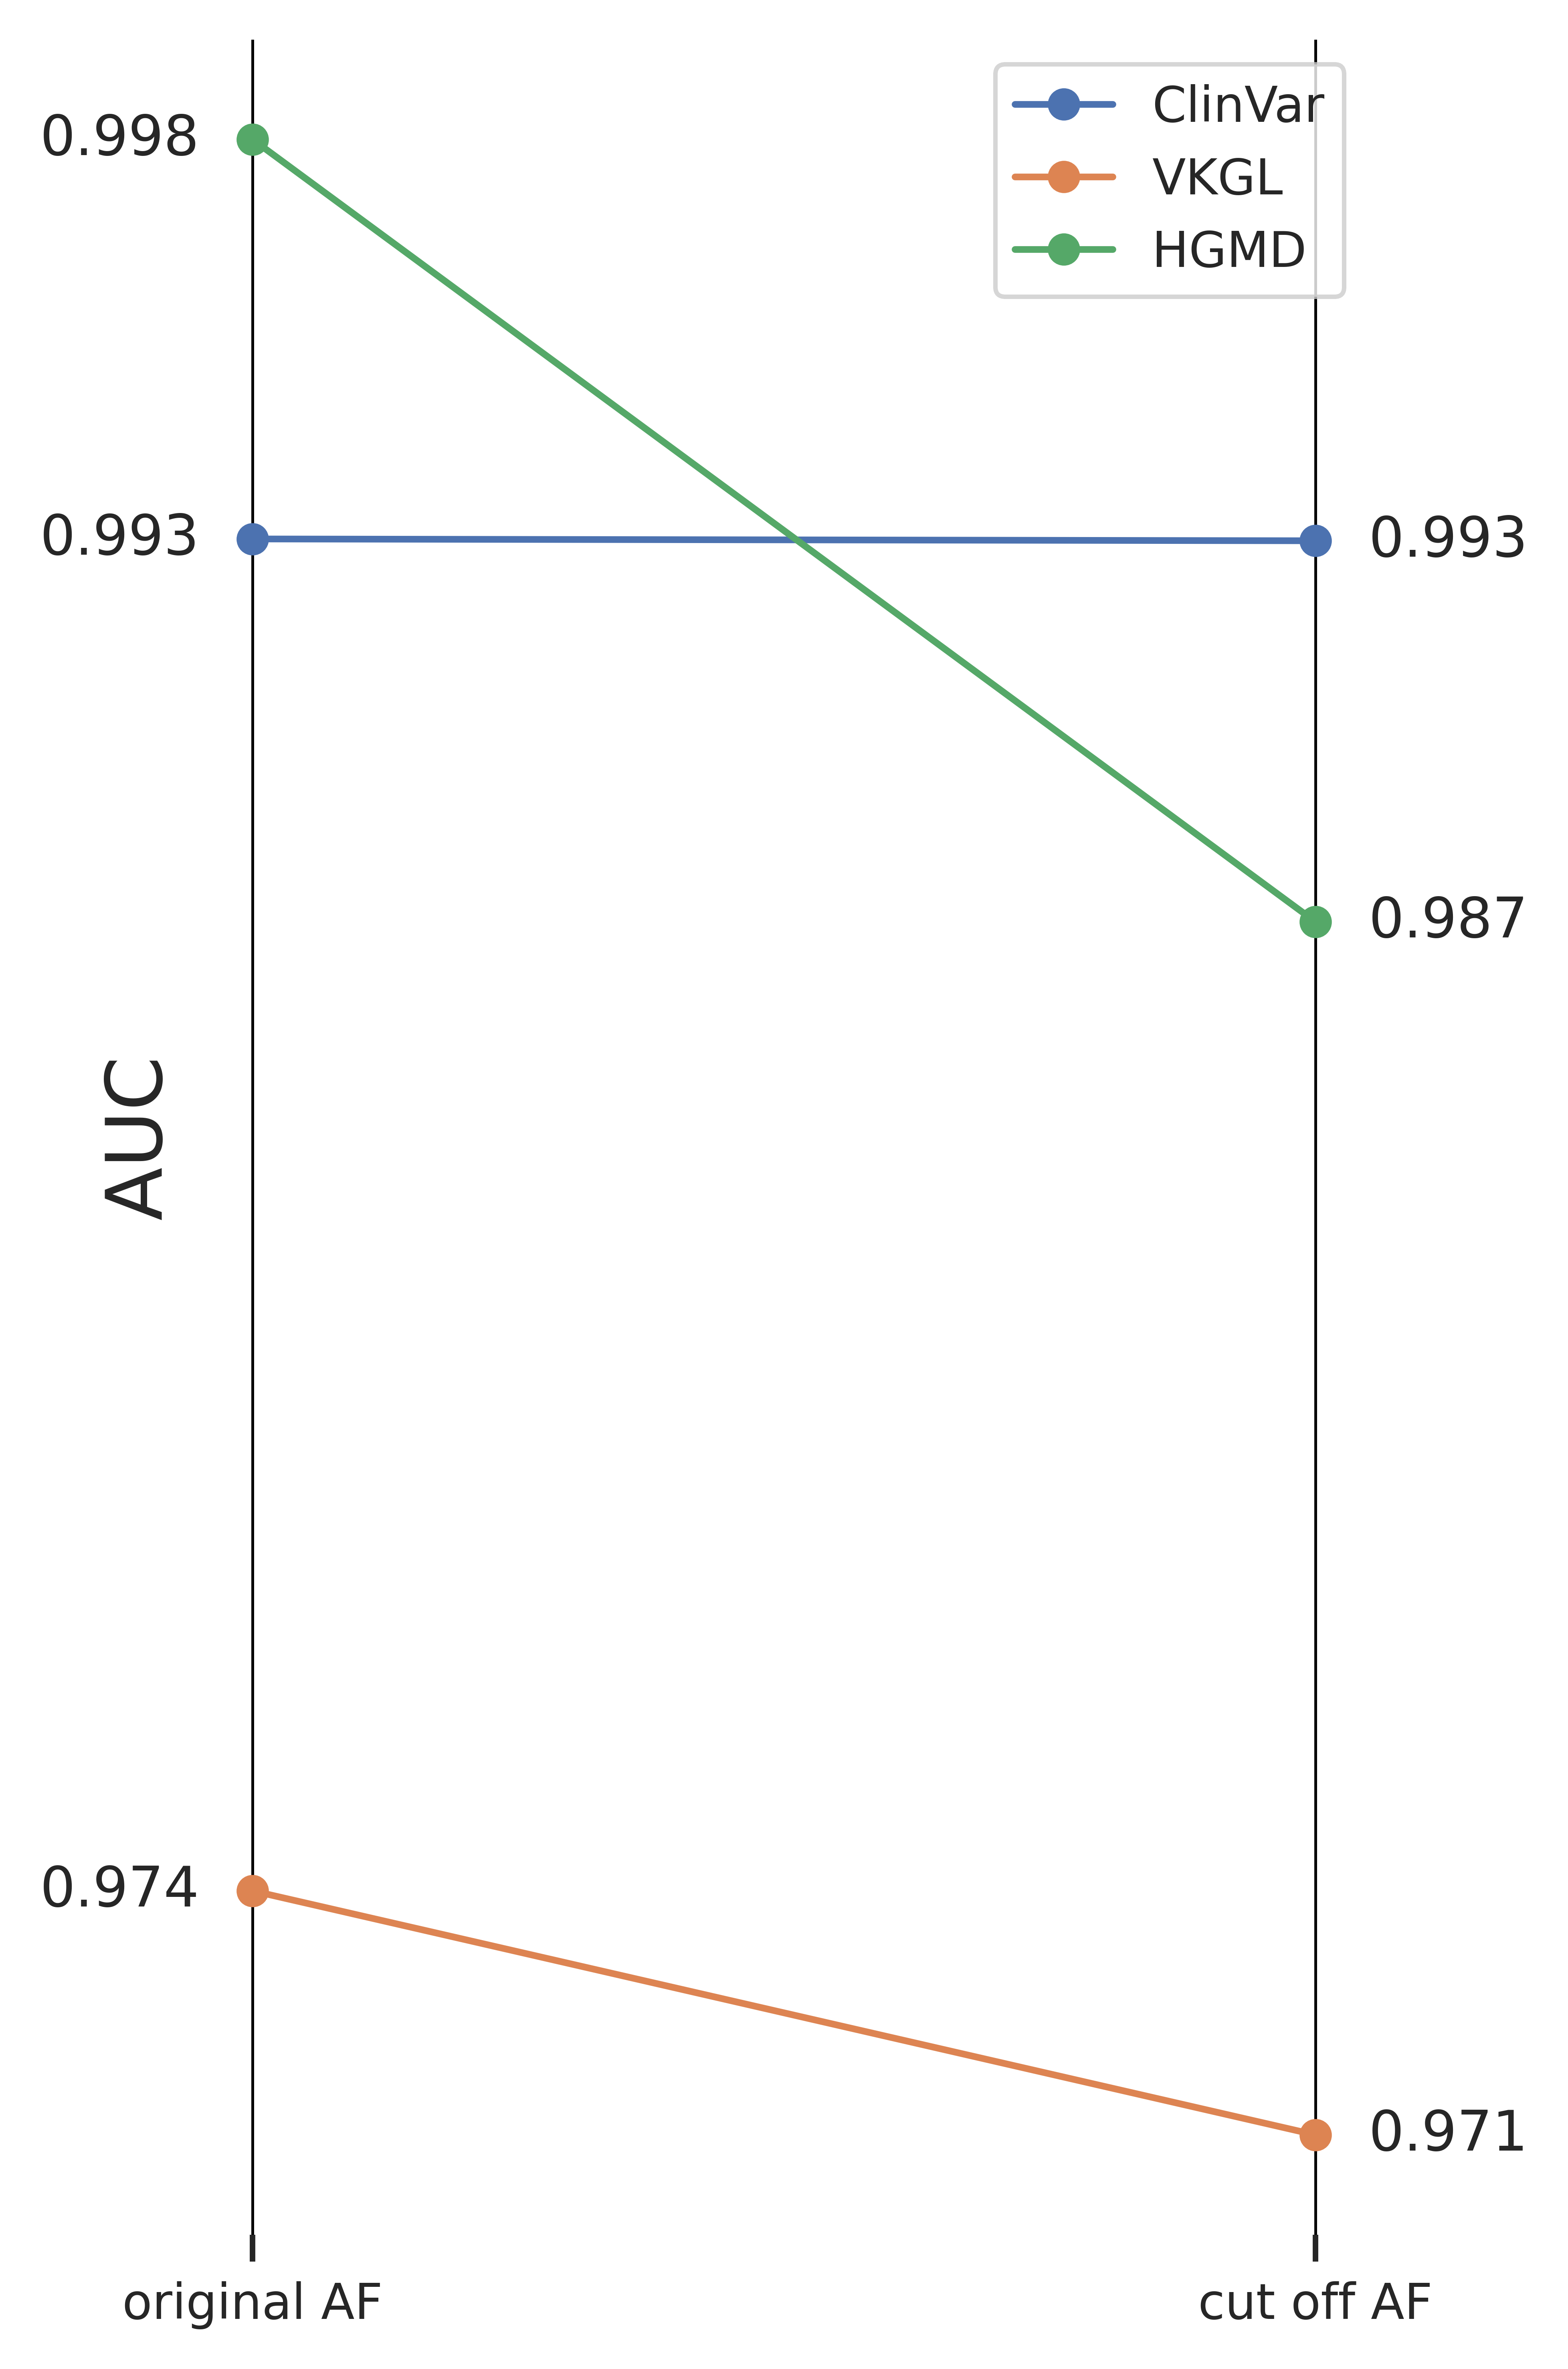

In [83]:
datasets = {
    'ClinVar': (clinvar_x, clinvar_y),
    'VKGL': (VKGL_x, VKGL_y),
    'HGMD': (HGMD_x, HGMD_y)
}

# 对每个数据集计算模型的AUC
auc_values = {
    dataset_name: (calculate_auc(model_best, x, y, "model_best"), calculate_auc(model_cutoff, x, y, "model_cutoff"))
    for dataset_name, (x, y) in datasets.items()
}

# 绘制坡度图
fig, ax = plt.subplots(1,1,figsize=(4,4), dpi= 1000)

positions = [1, 2]  # 用于x坐标的位置

for dataset_name, (auc1, auc2) in auc_values.items():
    plt.plot(positions, [auc1, auc2], marker='o', label=dataset_name)
  
    # 标注数字，对位置进行微调以确保清晰可读
    plt.text(positions[0]-0.05, auc1, f"{auc1:.3f}", ha='right', va='center', fontsize=10)
    plt.text(positions[1]+0.05, auc2, f"{auc2:.3f}", ha='left', va='center', fontsize=10)

plt.xticks(positions, ['original AF', 'cut off AF'])
plt.yticks([])
plt.ylabel('AUC', fontsize=14)
plt.legend(loc='best')
plt.grid(True, which='both', axis='x', linestyle='-', linewidth=0.5, color="black")
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.0)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.0)
plt.tight_layout()
plt.savefig(f"../final_fig/model_AF_cutoff_{loca}.pdf", format="pdf", dpi=1000, bbox_inches='tight')
plt.show()